# Exploratory Data Analysis

In this notebook, we will explore the air quality data of the city of Rio de Janeiro. From these results, we can gain insights into the machine learning algorithm. We divide the analysis as follows: 

1. Understading the data: what the data looks like, what are the information we have and what we can use;
2. Data exploration: visualizing the data and looking for some patterns; e
3. Data cleaning and feature engeneering.

## Understanding the data 

Load the necessary libraries and the data. 

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

## Definitions for the notebook

In [2]:
IMAGES_FOLDER = "../notes/images/"

sns.set()

pd.set_option('precision', 3)
pd.options.mode.chained_assignment = None

%matplotlib inline

## Structure of the dataset

In [3]:
air_data = pd.read_csv("../data/RiodeJaneiro_MonitorAr_hourly.csv")
air_data.head()

,Data,CodNum,Estação,Chuva,Pres,RS,Temp,UR,Dir_Vento,Vel_Vento,...,NO,NOx,O3,PM10,PM2_5,Lat,Lon,X_UTM_Sirgas2000,Y_UTM_Sirgas2000,OBJECTID
0,2012/01/01 00:30:00+00,2,BG,0.2,1008.15,NaN,24.67,95.24,NaN,NaN,...,2.18,17.36,28.06,81.0,NaN,-22.888,-43.471,656828.804,7.468e+06,1
1,2012/01/01 01:30:00+00,2,BG,0.4,1007.13,NaN,24.72,94.13,NaN,NaN,...,1.63,11.12,32.81,61.0,NaN,-22.888,-43.471,656828.804,7.468e+06,2
2,2012/01/01 02:30:00+00,2,BG,0.0,1006.32,NaN,24.49,92.91,NaN,NaN,...,1.73,10.47,31.61,26.0,NaN,-22.888,-43.471,656828.804,7.468e+06,3
3,2012/01/01 03:30:00+00,2,BG,0.2,1005.82,NaN,24.54,92.59,NaN,NaN,...,1.18,6.68,37.39,20.0,NaN,-22.888,-43.471,656828.804,7.468e+06,4
4,2012/01/01 04:30:00+00,2,BG,0.4,1005.45,NaN,24.78,90.71,NaN,NaN,...,0.95,9.35,33.45,7.0,NaN,-22.888,-43.471,656828.804,7.468e+06,5


### Monitored parameters

* `Data`: Date of the observation. 
* `CodNun`: Station code. 
* `Estação`: One of the monitoring stations given below. 
* `Chuva`: Rainfall (mm).
* `Pres`: Atmospheric Pressure (mbar).
* `RS` : Solar radiation (w/m2).
* `Temp`: Temperature (° C).
* `UR`: Relative humidity (%).
* `Dir_Vento`: Wind direction (°)
* `Vel_Vento`: Wind speed (m/s)
* `Lat`: Latitude position of the station 
* `Lon`: Longitude position of the station 
* `X_UTM_Sirgas2000`: Latitude in the Sirgas 2000 referential
* `Y_UTM_Sirgas2000`: Longitude in the Sirgas 2000 referential
* `OBJECTID`: Enumeration

### Stations and monitored gases
---

- Centro (CA): O3, CO, PM10
- Copacabana (AV): SO2, O3, CO, PM10
- São Cristóvão (SC): SO2,  O3, CO, PM10
- Tijuca (SP): SO2, NOx, O3, CO, PM10
- Irajá (IR): SO2, NOx, O3, CO, HC, PM2.5, PM10
- Bangu (BG): SO2, NOx, O3, CO, HC, PM10
- Campo Grande (CG): SO2, NOx, O3, CO, HC, PM10
- Pedra de Guaratiba (PG): O3, PM10

CO and HC are measured in (ppm), while the others are measured in (µg/m3).

In [4]:
air_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661662 entries, 0 to 661661
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Data              661662 non-null  object 
 1   CodNum            661662 non-null  int64  
 2   Estação           661662 non-null  object 
 3   Chuva             645850 non-null  float64
 4   Pres              646368 non-null  float64
 5   RS                613402 non-null  float64
 6   Temp              591045 non-null  float64
 7   UR                551043 non-null  float64
 8   Dir_Vento         571164 non-null  float64
 9   Vel_Vento         570919 non-null  float64
 10  SO2               464874 non-null  float64
 11  NO2               271157 non-null  float64
 12  HCNM              200083 non-null  float64
 13  HCT               199993 non-null  float64
 14  CH4               200140 non-null  float64
 15  CO                547483 non-null  float64
 16  NO                27

From these informations we can already see that some features are redundants. For instance, OBJECTID is the same as id, so we can remove it. The same with the colums CodNum and Estação, Lat/Lon and X/Y_UTM_Sirgas_2000. We will keep track of the relation in a dictionary and only keep the CodNum information and Lat/Lon. This will save around 20mb of information. We see that the gases have a lot of null values, because they are measured differently at each station, so we will keep them all. 

In [5]:
stations = air_data[['CodNum', 'Estação', 'X_UTM_Sirgas2000', 'Y_UTM_Sirgas2000']].drop_duplicates()
stations_info = zip(stations.Estação, stations.X_UTM_Sirgas2000, stations.Y_UTM_Sirgas2000)
stations = dict(zip(stations.CodNum, stations_info))

air_data.drop(labels = ['OBJECTID', 'Estação', 'X_UTM_Sirgas2000', 'Y_UTM_Sirgas2000'], axis = 1, inplace = True)

Convert the date to `datetime` dtype.

In [6]:
air_data.Data = pd.to_datetime(air_data.Data) 

air_data["year"] = air_data.Data.apply(lambda x: x.year)
air_data["month"] = air_data.Data.apply(lambda x: x.month)
air_data["day"] = air_data.Data.apply(lambda x: x.day)
air_data["hour"] = air_data.Data.apply(lambda x: x.hour)

## Missing and zero values

First, we see the missing values in the whole dataset

In [7]:
missing_values_df = air_data.isna().sum()
missing_values_prop_df = missing_values_df/air_data.shape[0]
for line, num in enumerate(missing_values_df):
    missing_values_df.iloc[line] = str(num) + " (" + str(100*missing_values_prop_df.iloc[line])[:4] + " %)"
missing_values_prop_df

Data         0.000
CodNum       0.000
Chuva        0.024
Pres         0.023
RS           0.073
Temp         0.107
UR           0.167
Dir_Vento    0.137
Vel_Vento    0.137
SO2          0.297
NO2          0.590
HCNM         0.698
HCT          0.698
CH4          0.698
CO           0.173
NO           0.590
NOx          0.590
O3           0.056
PM10         0.055
PM2_5        0.892
Lat          0.000
Lon          0.000
year         0.000
month        0.000
day          0.000
hour         0.000
dtype: float64

Observe that CO is not measured in Pedra de Guaratiba. If we desconsider it, the proportion falls for 6\%. 

In [8]:
(air_data[air_data.CodNum != 6].isna().sum()/air_data[air_data.CodNum != 6].shape[0]).loc['CO']

0.06281475851538401

The proportion of zero values is the following

In [9]:
zero_values_df = air_data.eq(0).sum()
zero_values_df/air_data.shape[0]

Data         0.000e+00
CodNum       0.000e+00
Chuva        9.097e-01
Pres         0.000e+00
RS           2.607e-01
Temp         1.285e-04
UR           6.348e-04
Dir_Vento    1.786e-03
Vel_Vento    6.358e-03
SO2          6.111e-02
NO2          6.045e-05
HCNM         7.313e-03
HCT          0.000e+00
CH4          0.000e+00
CO           1.535e-02
NO           1.662e-05
NOx          1.662e-05
O3           9.679e-03
PM10         1.953e-03
PM2_5        2.832e-03
Lat          0.000e+00
Lon          0.000e+00
year         0.000e+00
month        0.000e+00
day          0.000e+00
hour         4.167e-02
dtype: float64

In [10]:
consider_var = ['Chuva', 'Pres', 'RS', 'Temp', 'UR', 'Dir_Vento', 'Vel_Vento', 'CO', 'O3', 'PM10']
miss_per_year = air_data.groupby("year").agg(lambda x: pd.isna(x).sum()/len(x))[consider_var]
miss_per_code = air_data.groupby("CodNum").agg(lambda x: pd.isna(x).sum()/len(x))[consider_var]

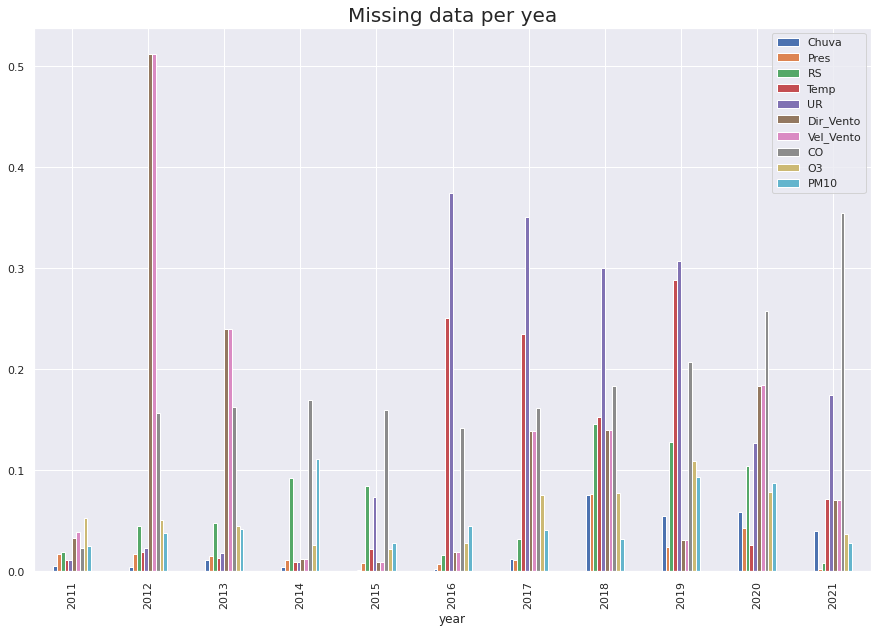

In [11]:
miss_per_year.plot.bar(figsize = (15,10))
plt.title('Missing data per yea', fontsize = 20)
plt.show()

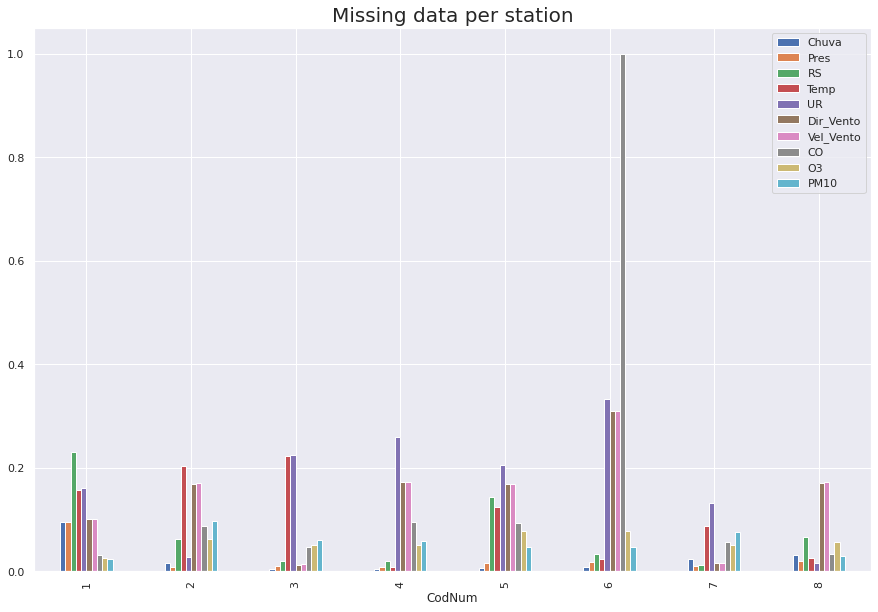

In [12]:
miss_per_code.plot.bar(figsize = (15,10))
plt.title('Missing data per station', fontsize = 20)
plt.show()

In [13]:
air_data_daily = air_data.groupby(["year", "month", "day", "hour"])[consider_var].sum(min_count=1)

In [14]:
air_data_daily.isna().sum()/air_data_daily.shape[0]

Chuva        2.241e-05
Pres         7.844e-05
RS           1.009e-04
Temp         1.009e-04
UR           1.121e-04
Dir_Vento    1.345e-04
Vel_Vento    1.233e-04
CO           1.233e-04
O3           1.233e-04
PM10         1.457e-04
dtype: float64

## Data visualization

Now we start to describe the features in this work and visualize them. 

In [15]:
pd.set_option("precision", 2)

In [16]:
air_data_desc = air_data[consider_var].describe()
air_data_desc.loc["skew"] = air_data[consider_var].skew()
air_data_desc.loc["kurt"] = air_data[consider_var].kurt()
air_data_desc

,Chuva,Pres,RS,Temp,UR,Dir_Vento,Vel_Vento,CO,O3,PM10
count,645850.00,646368.00,613402.00,591045.00,551043.00,571164.00,570919.00,547483.00,624529.00,625520.00
mean,0.13,1014.65,152.82,26.12,70.90,163.73,1.21,0.34,31.98,36.91
std,1.64,5.68,244.37,4.90,18.35,73.45,1.00,0.28,29.81,23.52
min,0.00,800.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,1011.12,0.00,22.67,58.39,100.00,0.55,0.14,8.68,21.00
50%,0.00,1014.30,6.17,25.54,72.75,166.17,0.92,0.29,24.52,32.00
75%,0.00,1018.02,224.00,28.99,85.08,222.50,1.55,0.46,46.89,47.00
max,426.60,1036.48,1864.67,49.08,100.00,358.83,25.50,12.08,355.45,994.00
skew,114.55,-7.32,1.61,0.55,-0.44,0.04,3.74,2.75,1.56,2.72
kurt,23177.40,282.90,1.48,0.33,-0.40,-0.97,47.30,24.85,3.71,38.67


In [17]:
air_data.Chuva.sort_values(ascending=False).iloc[0:20]

587813    426.6
587812    403.0
587724    387.9
587731    301.5
587725    274.6
587807    242.6
587728    213.4
587723    207.3
587806    203.4
587726    166.3
587814    148.2
587808    128.0
587732    117.0
587811    115.2
587722    115.2
241539     88.0
587805     85.4
587727     75.2
587809     73.6
589149     69.4
Name: Chuva, dtype: float64

In [18]:
air_data[air_data.Chuva>100]

,Data,CodNum,Chuva,Pres,RS,Temp,UR,Dir_Vento,Vel_Vento,SO2,...,NOx,O3,PM10,PM2_5,Lat,Lon,year,month,day,hour
587722,2020-05-04 15:30:00+00:00,8,115.2,1019.32,294.83,25.27,40.22,166.83,0.47,5.59,...,NaN,19.00,23.34,NaN,-22.92,-43.23,2020,5,4,15
587723,2020-05-04 16:30:00+00:00,8,207.3,1019.17,25.67,22.65,47.35,233.00,0.47,6.76,...,NaN,21.94,12.87,NaN,-22.92,-43.23,2020,5,4,16
587724,2020-05-04 17:30:00+00:00,8,387.9,1019.53,0.00,20.73,56.13,120.33,0.43,5.59,...,NaN,16.96,15.04,NaN,-22.92,-43.23,2020,5,4,17
587725,2020-05-04 18:30:00+00:00,8,274.6,1019.82,0.00,20.12,59.02,253.50,0.43,5.70,...,NaN,16.84,11.24,NaN,-22.92,-43.23,2020,5,4,18
587726,2020-05-04 19:30:00+00:00,8,166.3,1020.32,0.00,19.80,62.18,297.83,0.38,5.33,...,NaN,17.99,12.47,NaN,-22.92,-43.23,2020,5,4,19
587728,2020-05-04 21:30:00+00:00,8,213.4,1020.65,0.00,19.05,64.70,228.67,0.25,6.58,...,NaN,12.99,25.90,NaN,-22.92,-43.23,2020,5,4,21
587731,2020-05-05 00:30:00+00:00,8,301.5,1020.03,0.00,17.37,74.62,321.33,0.37,NaN,...,NaN,13.35,6.00,NaN,-22.92,-43.23,2020,5,5,0
587732,2020-05-05 01:30:00+00:00,8,117.0,1019.15,0.00,17.15,77.67,243.17,0.33,0.33,...,NaN,12.84,11.27,NaN,-22.92,-43.23,2020,5,5,1
587806,2020-05-08 03:30:00+00:00,8,203.4,1026.05,0.00,15.13,97.45,88.00,0.15,0.29,...,NaN,36.28,5.66,NaN,-22.92,-43.23,2020,5,8,3
587807,2020-05-08 04:30:00+00:00,8,242.6,1026.02,0.00,15.05,96.78,106.50,0.38,0.01,...,NaN,37.65,5.17,NaN,-22.92,-43.23,2020,5,8,4


In [19]:
air_data_daily = air_data.sort_values(by = "Data").groupby(["year","month","day"]).mean()

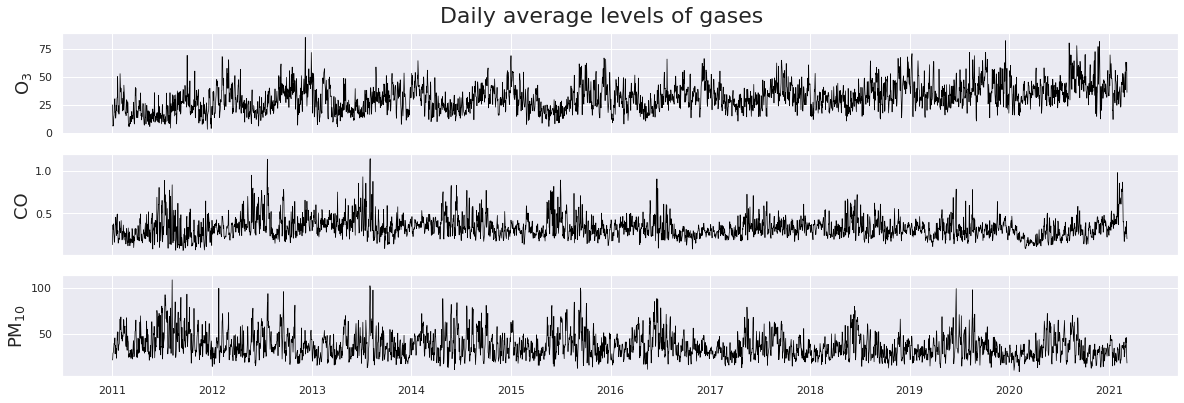

In [20]:
fig, ax = plt.subplots(3,1,figsize = (20,6), sharex = True)
air_data_daily.O3.plot(ax=ax[0], color='black',linewidth=0.7)
air_data_daily.CO.plot(ax=ax[1], color='black',linewidth=0.7)
air_data_daily.PM10.plot(ax=ax[2], color='black',linewidth=0.7,
                         xticks = [round(i*365.26) for i in range(11)])
ax[0].set_ylabel(r"O$_3$", fontsize = 18)
ax[1].set_ylabel(r"CO", fontsize = 18)
ax[2].set_ylabel(r"PM$_{10}$", fontsize = 18)
ax[2].set_xlabel("")

ax[2].set_xticklabels(labels=range(2011,2022))
fig.suptitle("Daily average levels of gases", fontsize = 22)
plt.subplots_adjust(top=0.92)

plt.savefig(IMAGES_FOLDER + "time-plots-gases.eps", bbox_inches="tight")

plt.show()

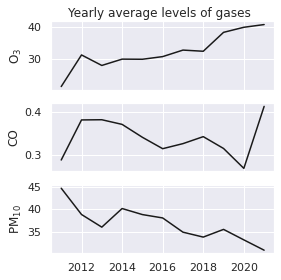

In [21]:
air_data_yearly = air_data.groupby("year").mean()[["O3", "CO", "PM10"]]

fig, ax = plt.subplots(3,1,figsize = (4,4), sharex = True)
air_data_yearly.O3.plot(ax=ax[0],xlabel='',color='k')
air_data_yearly.CO.plot(ax=ax[1],xlabel='',color='k')
air_data_yearly.PM10.plot(ax=ax[2],xlabel='',color='k')

ax[0].set_ylabel(r"O$_3$", fontsize = 12)
ax[1].set_ylabel(r"CO", fontsize = 12)
ax[2].set_ylabel(r"PM$_{10}$", fontsize = 12)

fig.suptitle("Yearly average levels of gases")
plt.subplots_adjust(top=0.93)

plt.savefig(IMAGES_FOLDER + "time-plots-gases-yearly.eps", bbox_inches="tight")

plt.show()

### Pairplot

In [22]:
air_data_daily_code = air_data.sort_values(by = "Data").groupby(["year","month"]).mean()[consider_var]

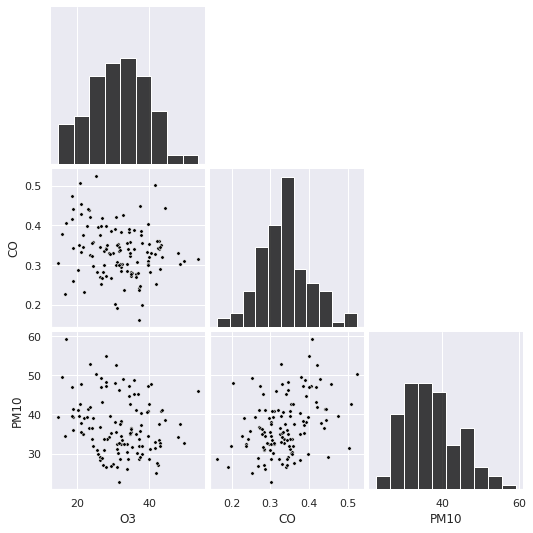

In [23]:
sns.pairplot(
    air_data_daily_code[["O3", "CO", "PM10"]],
    plot_kws=dict(marker=".", s=50, color='black'),
    diag_kws=dict(color="black"),
    corner=True
)

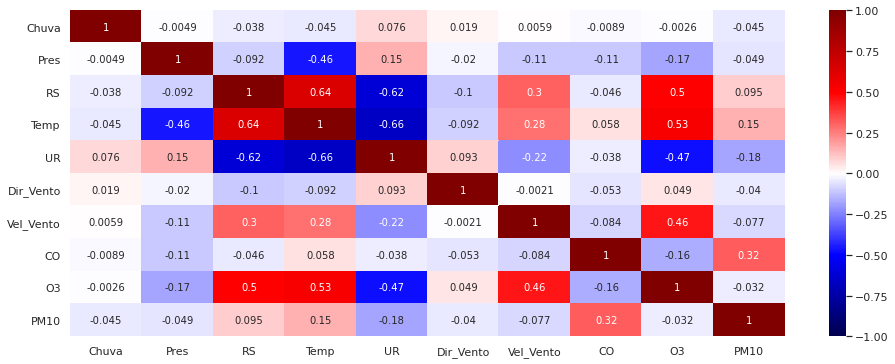

In [24]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(air_data[consider_var].corr(), vmin=-1, vmax=1, annot=True, cmap='seismic')
plt.savefig(IMAGES_FOLDER + "correlation-graph.eps", bbox_inches="tight")

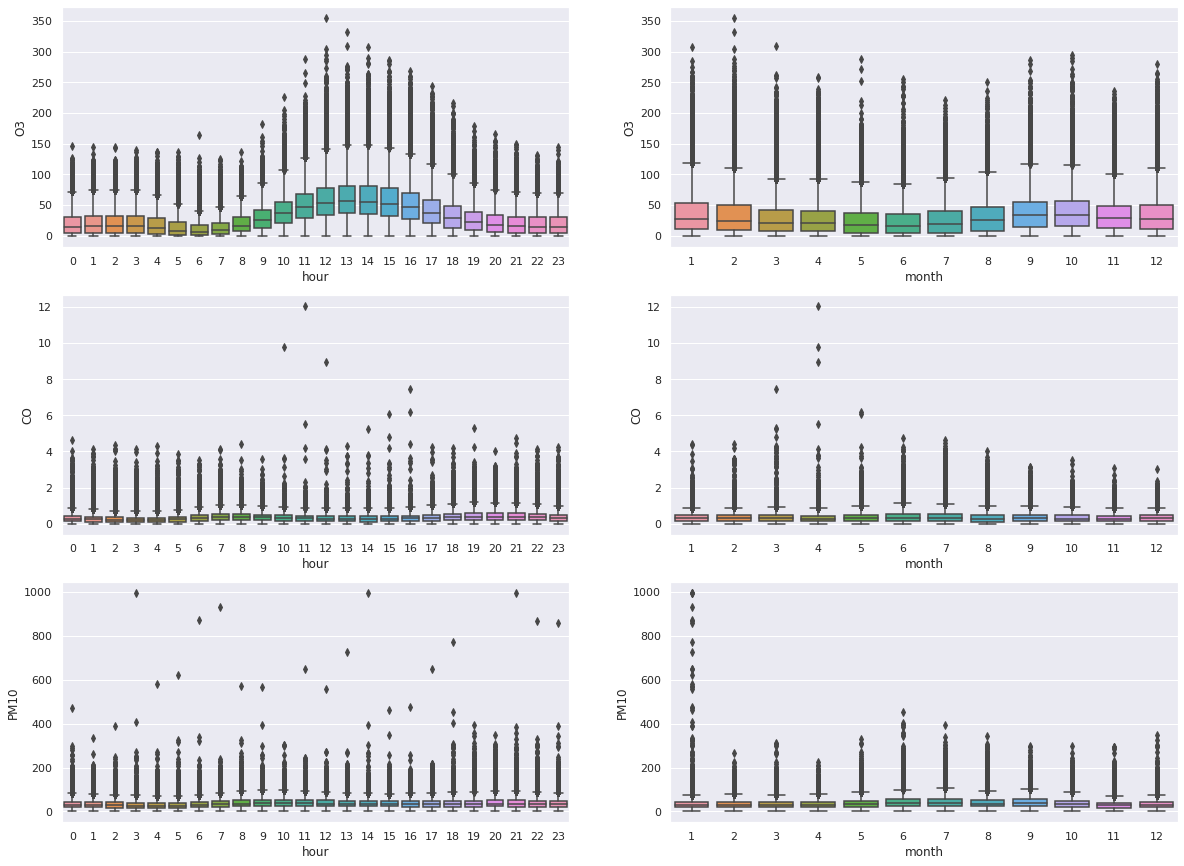

In [37]:
fig, ax = plt.subplots(3,2,figsize = (20,15))

sns.boxplot(x="hour", y="O3",   data=air_data, ax = ax[0][0])
sns.boxplot(x="hour", y="CO",   data=air_data, ax = ax[1][0])
sns.boxplot(x="hour", y="PM10", data=air_data, ax = ax[2][0])

sns.boxplot(x="month", y="O3",   data=air_data, ax = ax[0][1])
sns.boxplot(x="month", y="CO",   data=air_data, ax = ax[1][1])
sns.boxplot(x="month", y="PM10", data=air_data, ax = ax[2][1])

plt.show()

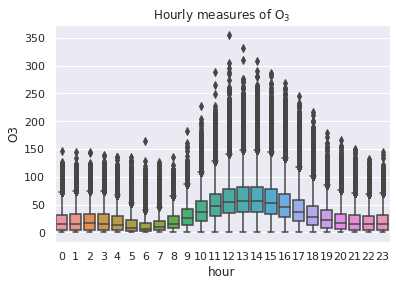

In [44]:
sns.boxplot(x="hour", y="O3", data=air_data)
plt.title(r"Hourly measures of O$_3$")
plt.savefig(IMAGES_FOLDER+"hourly_measure_o3.eps", bbox_inches="tight")
plt.show()